# Linear Regression

Try to apply a linear regression model to the merged otu table

In [1]:
import os
import csv
import logging

import biom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from skbio.stats.composition import multiplicative_replacement, clr

from src import project_directory
from src.database import get_session, Sample

In [2]:
session = get_session()
logging.basicConfig()
logging.getLogger('sqlalchemy.engine.Engine').setLevel(logging.ERROR)
_ = load_dotenv()

Ok simply load otu table and then add tissue as metadata:

In [3]:
biom_file = project_directory / "merged_results/export/table/feature-table.biom"
table = biom.load_table(biom_file)

In [4]:
# Get the list of samples in the OTU table
samples = table.ids(axis='sample')
print(samples[:10])

['H_10_S10_L001' 'H_11_S11_L001' 'H_12_S12_L001' 'H_13_S13_L001'
 'H_14_S14_L001' 'H_15_S15_L001' 'H_16_S16_L001' 'H_17_S17_L001'
 'H_18_S18_L001' 'H_19_S19_L001']


In [5]:
# Query the database for samples in the samples list and collect the tissue
queried_samples = session.query(Sample).filter(Sample.sample_id.in_(samples)).all()
sample2tissue = {sample.sample_id: sample.dataset.tissue for sample in queried_samples}

In [6]:
# Create an empty dataframe with the same indices as the samples
metadata = pd.DataFrame(index=samples)

# Add the tissue as new metadata
metadata['tissue'] = metadata.index.map(sample2tissue)

# Update the OTU table with the new metadata
table.add_metadata(metadata.to_dict(orient='index'), axis='sample')

# Verify that the tissue has been added correctly
print(table.metadata(axis='sample')[:3])

(defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fc610585800>, {'tissue': 'hindgut'}), defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fc610585bc0>, {'tissue': 'hindgut'}), defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fc610585c60>, {'tissue': 'hindgut'}))


Transform the otu table to a pandas dataframe and then add the tissue as metadata.
Table should be transposed to have samples as rows and otus as columns.

In [7]:
# Convert the OTU table to a dataframe
otu_df = pd.DataFrame(table.matrix_data.toarray(), index=table.ids(axis='observation'), columns=table.ids(axis='sample'))

# Add the tissue metadata as a new column
otu_df = otu_df.transpose()
otu_df['tissue'] = otu_df.index.map(sample2tissue)

In [8]:
otu_df["tissue"].value_counts()

tissue
milk       535
hindgut    141
rumen      118
feces       29
Name: count, dtype: int64

Transform tables:

In [9]:
X = otu_df.drop(columns=["tissue"])
y = otu_df["tissue"]

Convert counts to relative abundances:

In [10]:
X_relative = X.div(X.sum(axis=1), axis=0)

Split into train and test sets:

In [11]:
# random_state:
# https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn
X_train, X_test, y_train, y_test = train_test_split(X_relative, y, test_size=0.3, random_state=42)

deal with compositionality using clr transformation:

In [12]:
X_train_comp = multiplicative_replacement(X_train.values)
X_test_comp = multiplicative_replacement(X_test.values)

X_train_clr = clr(X_train_comp)
X_test_clr = clr(X_test_comp)

/home/cozzip/.cache/pypoetry/virtualenvs/deep-micro-core-QWG9m0ME-py3.12/lib/python3.12/site-packages/skbio/util/_warning.py:42: DeprecationWarning: `multiplicative_replacement` was renamed to `multi_replace` in 0.6.0. The old name is kept as an alias but is deprecated.
  warn(message, warning)


## Creating a model

In [13]:
model = LogisticRegression(solver="liblinear", max_iter=int(os.getenv("MAX_ITER", 1000)))

In [14]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}

In [15]:
grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=int(os.getenv("MAX_CPUS", -1)), verbose=1, cv=5)

In [16]:
grid_search.fit(X_train_clr, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/cozzip/.cache/pypoetry/virtualenvs/deep-micro-core-QWG9m0ME-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=3221128) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/cozzip/.cache/pypoetry/virtualenvs/deep-micro-core-QWG9m0ME-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=3221128) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [17]:
grid_search.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [18]:
y_pred = grid_search.predict(X_test_clr)

In [19]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

       feces       1.00      1.00      1.00         9
     hindgut       1.00      1.00      1.00        48
        milk       1.00      1.00      1.00       161
       rumen       1.00      1.00      1.00        29

    accuracy                           1.00       247
   macro avg       1.00      1.00      1.00       247
weighted avg       1.00      1.00      1.00       247



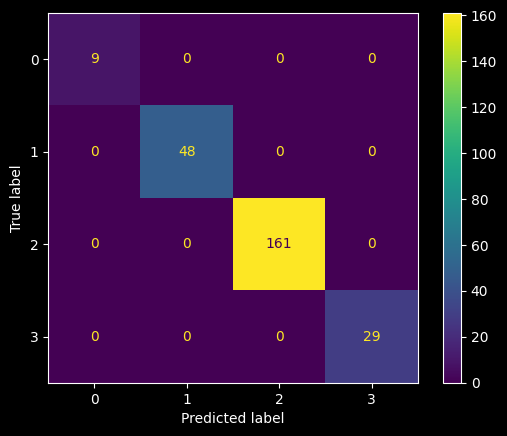

In [20]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The same confusion matrix as before but with class labels:

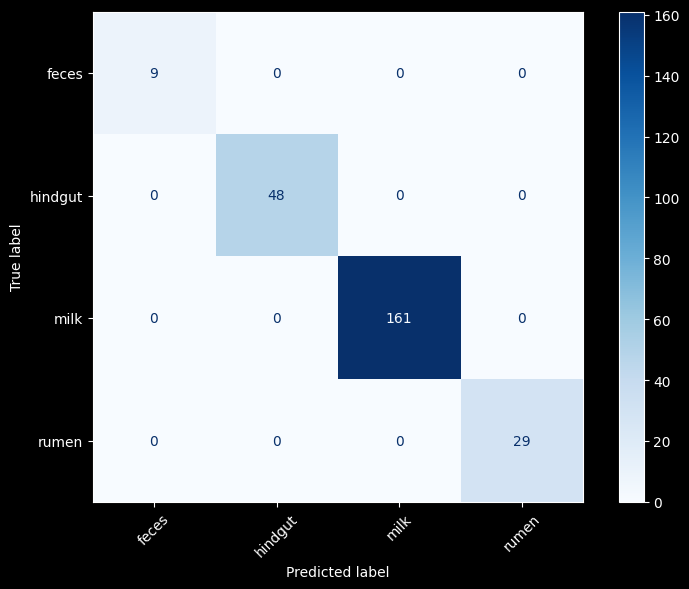

In [21]:
# fallback: unione ordinata di y_true e y_pred per garantire tutte le etichette
class_names = np.unique(np.concatenate([y_test.astype(str), y_pred.astype(str)]))

# Ricomponi la confusion matrix usando le etichette testuali e visualizza
cm = confusion_matrix(y_test, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", values_format='d')
plt.tight_layout()
plt.show()

Get the best model and save it to a file:

In [22]:
best_model = grid_search.best_estimator_
joblib.dump(best_model, project_directory / "notebooks/logistic_regression_model.pkl")

['/home/cozzip/deep_micro_core/notebooks/logistic_regression_model.pkl']

Now try to collect the coefficients to identify the features that are more important for the model.

In [23]:
coefficients = best_model.coef_[0]
feature_importance = pd.DataFrame({'Feature ID': X.columns, 'Coefficient': coefficients})
feature_importance['Importance'] = np.abs(feature_importance['Coefficient'])
feature_importance.set_index('Feature ID', inplace=True)
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance.head(10)

,Coefficient,Importance
Feature ID,,
565b4f421328126f98e9f2aff31630f1,-0.015610,0.015610
b02a8d33d018119dedb2db15db887bfd,-0.015303,0.015303
d68ce1ee602aa886d34ef344207522ab,-0.015078,0.015078
f40835abe0e1671143610c20a462cf32,-0.013770,0.013770
432f86dea632b7903d433caf26431565,-0.013053,0.013053
c6b516ae2ba507f85cf0eede12bfa499,-0.012523,0.012523
26cf4b3a1d8ec76ae515ab623941648b,-0.011337,0.011337
5497318e515a8c328a68f95975d9c7d4,-0.010993,0.010993
f87045bf18de1e8f760333c4b6e37c03,-0.010831,0.010831


try to load the taxononies from file

In [24]:
taxonomy_file = project_directory / "merged_results/export/taxonomy/taxonomy.tsv"

with open(taxonomy_file, 'r') as handle:
    reader = csv.DictReader(handle, delimiter='\t')
    taxonomies = [row for row in reader]

taxonomies = {row['Feature ID']: row["Taxon"] for row in taxonomies}
taxonomies = {key: value.split(";")[:-1] for key, value in taxonomies.items()}
taxonomies = pd.DataFrame.from_dict(taxonomies, orient='index', columns=[f"Level_{i}" for i in range(1, 9)])
taxonomies.index.name = "Feature ID"
taxonomies.head()

,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,
00005da053b2c7b99c1f46889cbd7d33,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodospirillales,,,,
000064ab480f315e268221d5ee0f9297,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Selenomonadaceae,Anaerovibrio,,
0000a8e3cb4978e30b6883f2f22e858a,,,,,,,,
0000e116cc2f5406e876821a7c052ded,Bacteria,Chloroflexi,Chloroflexia,Chloroflexales,Roseiflexaceae,,,
00020917fc43975b5caf2db2eefdb58e,Bacteria,,,,,,,


In [25]:
merged_df = feature_importance.merge(taxonomies, left_index=True, right_index=True, how="inner")
merged_df.to_csv(project_directory / "notebooks/feature_importance.csv", index=False)
merged_df.head()

,Coefficient,Importance,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,,,
565b4f421328126f98e9f2aff31630f1,-0.015610,0.015610,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Erwiniaceae,Pantoea,vagans,
b02a8d33d018119dedb2db15db887bfd,-0.015303,0.015303,Bacteria,Actinobacteriota,Actinobacteria,Propionibacteriales,Propionibacteriaceae,Cutibacterium,acnes,
d68ce1ee602aa886d34ef344207522ab,-0.015078,0.015078,Bacteria,Actinobacteriota,Actinobacteria,Pseudonocardiales,Pseudonocardiaceae,Prauserella,aidingensis,
f40835abe0e1671143610c20a462cf32,-0.013770,0.013770,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Erwiniaceae,Pantoea,,agglomerans
432f86dea632b7903d433caf26431565,-0.013053,0.013053,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Erwiniaceae,Pantoea,vagans,
